> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, we select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [1]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#tf.logging.set_verbosity(tf.logging.ERROR)

/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
tf.__version__

'1.12.0'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 175104712849708921
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16508640603342311580
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10308679152549067118
physical_device_desc: "device: XLA_GPU device"
]


In [277]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32)#tf.Variable([0.005], dtype=tf.float32)
            self.D_s = tf.constant(0.2, dtype=tf.float32)#tf.Variable([0.2], dtype=tf.float32)
            self.sigma_a = tf.constant(0.0, dtype=tf.float32)#tf.Variable([0.0], dtype=tf.float32)
            self.sigma_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.mu_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.kappa_a = tf.constant(0.25, dtype=tf.float32)#tf.Variable([0.25], dtype=tf.float32)

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")

        self.loss = self.loss_1 + self.loss_a + self.loss_s        

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss},\n"
              f"D_a: {D_a:.4f}, D_s: {D_s:.4f}\n"
              f"sigma_a: {sigma_a:.4f}, sigma_s: {sigma_s:.4f}\n"
              f"rho_a: {rho_a:.4f}, rho_s: {rho_s:.4f}\n"
              f"mu_a: {mu_a:.4f}, kappa_a: {kappa_a:.4f}\n")
        
      
    def train(self, nIter, early_stop_thresh = None): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"It: {it}, loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"It: {it}, loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss, self.D_a, self.D_s,
        #                                  self.sigma_a, self.sigma_s,
        #                                  self.rho_a, self.rho_s,
        #                                  self.mu_a, self.kappa_a],
        #                        loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [299]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [280]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
model.train(400000, early_stop_thresh=3200.0)

It: 0, loss_a  : 0.00583334, loss_s  : 13.07013893, loss  : 93115.07,
It: 0, loss_a/N: 0.00000018, loss_s/N: 0.00039887, loss/N: 2.84164643,
Time:5.54

It: 100, loss_a  : 0.00444512, loss_s  : 0.05034296, loss  : 9905.47,
It: 100, loss_a/N: 0.00000014, loss_s/N: 0.00000154, loss/N: 0.30229110,
Time:100.86

It: 200, loss_a  : 0.00287922, loss_s  : 0.03684629, loss  : 9898.46,
It: 200, loss_a/N: 0.00000009, loss_s/N: 0.00000112, loss/N: 0.30207700,
Time:100.83

It: 300, loss_a  : 0.00262002, loss_s  : 0.03401168, loss  : 9894.83,
It: 300, loss_a/N: 0.00000008, loss_s/N: 0.00000104, loss/N: 0.30196631,
Time:100.64

It: 400, loss_a  : 0.00244752, loss_s  : 0.03211090, loss  : 9892.19,
It: 400, loss_a/N: 0.00000007, loss_s/N: 0.00000098, loss/N: 0.30188555,
Time:100.64

It: 500, loss_a  : 0.00232900, loss_s  : 0.03079350, loss  : 9890.05,
It: 500, loss_a/N: 0.00000007, loss_s/N: 0.00000094, loss/N: 0.30182028,
Time:100.83

It: 600, loss_a  : 0.00225003, loss_s  : 0.02990273, loss  : 9888.10

It: 5300, loss_a  : 0.00372137, loss_s  : 0.13578850, loss  : 9581.70,
It: 5300, loss_a/N: 0.00000011, loss_s/N: 0.00000414, loss/N: 0.29241014,
Time:100.79

It: 5400, loss_a  : 0.00403111, loss_s  : 0.15196818, loss  : 9573.42,
It: 5400, loss_a/N: 0.00000012, loss_s/N: 0.00000464, loss/N: 0.29215744,
Time:101.03

It: 5500, loss_a  : 0.00359465, loss_s  : 0.16084278, loss  : 9562.37,
It: 5500, loss_a/N: 0.00000011, loss_s/N: 0.00000491, loss/N: 0.29182038,
Time:100.69

It: 5600, loss_a  : 0.00412955, loss_s  : 0.17224050, loss  : 9556.80,
It: 5600, loss_a/N: 0.00000013, loss_s/N: 0.00000526, loss/N: 0.29165044,
Time:100.98

It: 5700, loss_a  : 0.00386694, loss_s  : 0.18181527, loss  : 9543.72,
It: 5700, loss_a/N: 0.00000012, loss_s/N: 0.00000555, loss/N: 0.29125136,
Time:100.86

It: 5800, loss_a  : 0.00406085, loss_s  : 0.18536612, loss  : 9531.75,
It: 5800, loss_a/N: 0.00000012, loss_s/N: 0.00000566, loss/N: 0.29088607,
Time:100.71

It: 5900, loss_a  : 0.00337820, loss_s  : 0.17164686

In [342]:
model.train(400000, early_stop_thresh=320.0)

It: 0, loss_a  : 0.02123090, loss_s  : 2.21025205, loss  : 3194.07,
It: 0, loss_a/N: 0.00000065, loss_s/N: 0.00006745, loss/N: 0.09747516,
Time:1.01

It: 100, loss_a  : 0.02145929, loss_s  : 2.29587626, loss  : 2926.58,
It: 100, loss_a/N: 0.00000065, loss_s/N: 0.00007006, loss/N: 0.08931218,
Time:100.82

It: 200, loss_a  : 0.02146381, loss_s  : 2.32675552, loss  : 2712.71,
It: 200, loss_a/N: 0.00000066, loss_s/N: 0.00007101, loss/N: 0.08278532,
Time:100.85

It: 300, loss_a  : 0.02249672, loss_s  : 2.41232681, loss  : 2746.06,
It: 300, loss_a/N: 0.00000069, loss_s/N: 0.00007362, loss/N: 0.08380312,
Time:100.73

It: 400, loss_a  : 0.02284313, loss_s  : 2.44745469, loss  : 2354.79,
It: 400, loss_a/N: 0.00000070, loss_s/N: 0.00007469, loss/N: 0.07186246,
Time:100.85

It: 500, loss_a  : 0.02917548, loss_s  : 2.68305755, loss  : 2575.76,
It: 500, loss_a/N: 0.00000089, loss_s/N: 0.00008188, loss/N: 0.07860588,
Time:100.85

It: 600, loss_a  : 0.02051643, loss_s  : 2.26202536, loss  : 1811.44,


In [351]:
model.train(400000, early_stop_thresh=32.0)

It: 0, loss_a  : 0.01376578, loss_s  : 1.18704557, loss  : 320.91,
It: 0, loss_a/N: 0.00000042, loss_s/N: 0.00003623, loss/N: 0.00979328,
Time:1.01

It: 100, loss_a  : 0.01346802, loss_s  : 1.15123963, loss  : 269.41,
It: 100, loss_a/N: 0.00000041, loss_s/N: 0.00003513, loss/N: 0.00822181,
Time:100.76

It: 200, loss_a  : 0.01317475, loss_s  : 1.11737525, loss  : 241.53,
It: 200, loss_a/N: 0.00000040, loss_s/N: 0.00003410, loss/N: 0.00737086,
Time:100.69

It: 300, loss_a  : 0.01298307, loss_s  : 1.08652747, loss  : 221.64,
It: 300, loss_a/N: 0.00000040, loss_s/N: 0.00003316, loss/N: 0.00676387,
Time:100.89

It: 400, loss_a  : 0.01255095, loss_s  : 1.05796432, loss  : 215.95,
It: 400, loss_a/N: 0.00000038, loss_s/N: 0.00003229, loss/N: 0.00659023,
Time:100.69

It: 500, loss_a  : 0.01244000, loss_s  : 1.02833021, loss  : 194.02,
It: 500, loss_a/N: 0.00000038, loss_s/N: 0.00003138, loss/N: 0.00592091,
Time:100.96

It: 600, loss_a  : 0.01214173, loss_s  : 1.00633085, loss  : 184.93,
It: 600

It: 5300, loss_a  : 0.00765650, loss_s  : 0.59032977, loss  : 74.87,
It: 5300, loss_a/N: 0.00000023, loss_s/N: 0.00001802, loss/N: 0.00228482,
Time:100.83

It: 5400, loss_a  : 0.00785853, loss_s  : 0.57977831, loss  : 64.88,
It: 5400, loss_a/N: 0.00000024, loss_s/N: 0.00001769, loss/N: 0.00198011,
Time:100.83

It: 5500, loss_a  : 0.00781216, loss_s  : 0.57591534, loss  : 64.04,
It: 5500, loss_a/N: 0.00000024, loss_s/N: 0.00001758, loss/N: 0.00195431,
Time:100.93

It: 5600, loss_a  : 0.00814337, loss_s  : 0.57158875, loss  : 76.74,
It: 5600, loss_a/N: 0.00000025, loss_s/N: 0.00001744, loss/N: 0.00234178,
Time:100.81

It: 5700, loss_a  : 0.00776277, loss_s  : 0.56887114, loss  : 62.24,
It: 5700, loss_a/N: 0.00000024, loss_s/N: 0.00001736, loss/N: 0.00189928,
Time:100.87

It: 5800, loss_a  : 0.00761048, loss_s  : 0.56685090, loss  : 67.38,
It: 5800, loss_a/N: 0.00000023, loss_s/N: 0.00001730, loss/N: 0.00205634,
Time:100.89

It: 5900, loss_a  : 0.00985780, loss_s  : 0.60000610, loss  : 17

It: 10600, loss_a  : 0.00618940, loss_s  : 0.44660291, loss  : 35.67,
It: 10600, loss_a/N: 0.00000019, loss_s/N: 0.00001363, loss/N: 0.00108865,
Time:100.77

It: 10700, loss_a  : 0.00809588, loss_s  : 0.49285626, loss  : 215.95,
It: 10700, loss_a/N: 0.00000025, loss_s/N: 0.00001504, loss/N: 0.00659013,
Time:100.67

It: 10800, loss_a  : 0.00624126, loss_s  : 0.44726199, loss  : 39.57,
It: 10800, loss_a/N: 0.00000019, loss_s/N: 0.00001365, loss/N: 0.00120753,
Time:100.76

It: 10900, loss_a  : 0.00577208, loss_s  : 0.47031498, loss  : 109.94,
It: 10900, loss_a/N: 0.00000018, loss_s/N: 0.00001435, loss/N: 0.00335503,
Time:100.71

It: 11000, loss_a  : 0.00615426, loss_s  : 0.43909419, loss  : 33.88,
It: 11000, loss_a/N: 0.00000019, loss_s/N: 0.00001340, loss/N: 0.00103382,
Time:100.75

It: 11100, loss_a  : 0.00607570, loss_s  : 0.43705979, loss  : 36.00,
It: 11100, loss_a/N: 0.00000019, loss_s/N: 0.00001334, loss/N: 0.00109876,
Time:100.71

It: 11200, loss_a  : 0.00612540, loss_s  : 0.51277

In [352]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[-T:]#[50000]#t_star[-T:]#t_star[index]#0#5000000

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [353]:
t_2.shape

(32768, 1)

In [354]:
t_test

array([46966.73189824, 47064.57925636, 47162.42661448, 47260.2739726 ,
       47358.12133072, 47455.96868885, 47553.81604697, 47651.66340509,
       47749.51076321, 47847.35812133, 47945.20547945, 48043.05283757,
       48140.90019569, 48238.74755382, 48336.59491194, 48434.44227006,
       48532.28962818, 48630.1369863 , 48727.98434442, 48825.83170254,
       48923.67906067, 49021.52641879, 49119.37377691, 49217.22113503,
       49315.06849315, 49412.91585127, 49510.76320939, 49608.61056751,
       49706.45792564, 49804.30528376, 49902.15264188, 50000.        ])

In [355]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:a_train,
           model.s_tf:s_train}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_2 = model.sess.run(model.loss, tf_dict)

print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss   : {l_2:.8f}")
print( f"Loss Diff  : {l_2-l_a_2-l_s_2:.8f}")

Loss_a : 0.00597024
Loss_s : 0.42855284
Loss   : 31.96447372
Loss Diff  : 31.52995110


In [356]:
print(np.sum(np.power(a_2 - a_train,2)))
print(np.sum(np.power(s_2 - s_train,2)))
print(np.sum(np.power(a_2 - a_train,2)) +
      np.sum(np.power(s_2 - s_train,2)))

28.58617129683161
2.943780440721339
31.52995173755295


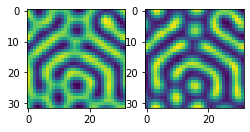

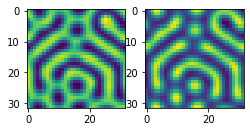

In [358]:
start = 0
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, -1].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, -1].reshape((x_size,y_size)))
plt.show()



In [71]:
T

10

In [377]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = 100000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [378]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00023321
Loss_s : 0.01421646
Loss   : 35.84325027


In [379]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

32.91175689948149
2.9170470648805997


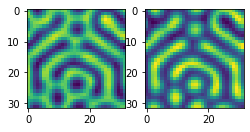

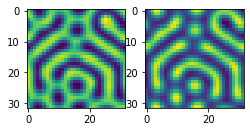

In [380]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [363]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_full_32_steps', global_step=0)

'./PINN_Turring_model_loss_full_32_steps-0'

In [364]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_19:0
y_tf_19:0
t_tf_19:0
a_pred_19:0
s_pred_19:0
add_253:0
loss_a_19:0
loss_s_19:0
